Imports

In [105]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random

Base

In [107]:
df = pd.read_excel("normalizacao/normalizado-Amaro.xlsx",header = None)
len(df)

611

In [108]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,Normal,797766418.0,7.976836e+08,7.976132e+08,7.976932e+08,7.978051e+08,7.977534e+08,7.975633e+08,7.980001e+08,7.985450e+08,...,5.927387e+08,5.925812e+08,5.925742e+08,5.926284e+08,5.926800e+08,5.924132e+08,5.924986e+08,5.927184e+08,5.927748e+08,592758179.0
1,Normal,592893188.0,5.929576e+08,5.930038e+08,5.930056e+08,5.929661e+08,5.928822e+08,5.928130e+08,5.928260e+08,5.928952e+08,...,7.945067e+08,7.944689e+08,7.945062e+08,7.945400e+08,7.945050e+08,7.944806e+08,7.945024e+08,7.944988e+08,7.944228e+08,794261597.0
2,Normal,794196960.0,7.942114e+08,7.942750e+08,7.942332e+08,7.941412e+08,7.941456e+08,7.941471e+08,7.945786e+08,7.952045e+08,...,5.899185e+08,5.897557e+08,5.897092e+08,5.897825e+08,5.898335e+08,5.897254e+08,5.896366e+08,5.896476e+08,5.898321e+08,590020081.0
3,Normal,590020813.0,5.899802e+08,5.899391e+08,5.899551e+08,5.899282e+08,5.899542e+08,5.899806e+08,5.900231e+08,5.900554e+08,...,7.983703e+08,7.984350e+08,7.984996e+08,7.985776e+08,7.986325e+08,7.985593e+08,7.984473e+08,7.983986e+08,7.983111e+08,798115662.0
4,Normal,798007568.0,7.979743e+08,7.978910e+08,7.978479e+08,7.977852e+08,7.976765e+08,7.977107e+08,7.977559e+08,7.977479e+08,...,5.907331e+08,5.906532e+08,5.905842e+08,5.906232e+08,5.906981e+08,5.906141e+08,5.905779e+08,5.905933e+08,5.906006e+08,590630615.0


In [109]:
df_x = df.drop([0],axis=1)

In [110]:
print(df[0].unique())

['Normal' 'Duplo' 'Ritmo']


In [111]:
# Classificando Normal = 0 e outros comportamentos como = 1
df['fadiga'] = [0 if x == 'Normal' else 1 for x in df[0]]
df['classes_completa'] = [0 if x == 'Normal' else 1 if x == 'Duplo' else 2 for x in df[0]]
df_y =  df['fadiga']
df_y_real = df['classes_completa']

In [112]:
count = 0
for i in df_y:
    if i == 0:
        count += 1
print(f'% de Normal: {count/len(df_y) * 100}')

% de Normal: 88.54337152209493


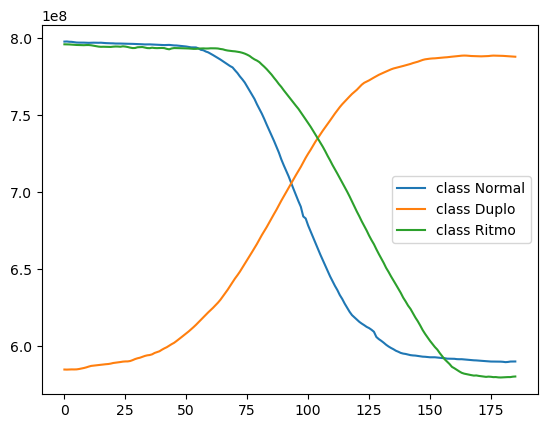

In [113]:
#Mostrando exemplos de cada classe
classes = np.unique(df_y_real, axis=0)
idx = np.random.default_rng(seed=42).permutation(len(df_x))
nova_df_x = df_x.values[idx]
nova_df_y = df_y_real.values[idx]
plt.figure()
for c in classes:
    c_x_train = nova_df_x[nova_df_y == c]
    if c == 0:
        text = 'Normal'
    if c == 1:
        text = 'Duplo'
    if c == 2:
        text = 'Ritmo'
    plt.plot(c_x_train[0], label="class " + str(text))
plt.legend(loc="best")
plt.show()
plt.close()

Treino e Teste

In [115]:
#Randomizar a ordem
idx = np.random.permutation(len(nova_df_x))
nova_df_x = df_x.values[idx]
nova_df_y = df_y.values[idx]

#Separar em Treino (70%), Validação (20%) e Teste (10%)
n = len(nova_df_x)
train_df_x = nova_df_x[0:int(n*0.7)]
val_df_x = nova_df_x[int(n*0.7):int(n*0.9)]
test_df_x = nova_df_x[int(n*0.9):]

train_df_y = nova_df_y[0:int(n*0.7)]
val_df_y = nova_df_y[int(n*0.7):int(n*0.9)]
test_df_y = nova_df_y[int(n*0.9):]

train_x,train_y = train_df_x,train_df_y
val_x,val_y = val_df_x,val_df_y
test_x,test_y = test_df_x,test_df_y
num_features = test_df_x.shape[1]

Normalização

In [117]:
train_mean = train_x.mean()
train_std = train_x.std()

train_x = (train_x - train_mean) / train_std
val_x = (val_x - train_mean) / train_std
test_x = (test_x - train_mean) / train_std

In [118]:
num_classes = len(np.unique(train_y))

In [119]:
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
val_x = val_x.reshape((val_x.shape[0], val_x.shape[1], 1))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [120]:
train_x.shape

(427, 186, 1)

Modelo

In [122]:
def make_model_lstm(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)
    lstm1 = tf.keras.layers.LSTM(16,return_sequences=True)(input_layer)
    lstm2 = tf.keras.layers.LSTM(8)(lstm1)
    output_layer = tf.keras.layers.Dense(num_classes)(lstm2)
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [123]:
def make_model_rnn(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)
    rnn1 = tf.keras.layers.SimpleRNN(16,return_sequences=True)(input_layer)
    rnn2 = tf.keras.layers.SimpleRNN(8)(rnn1)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(rnn2)
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [124]:
def make_model_cnn(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)
    cn2 = tf.keras.layers.Conv1D(32,kernel_size=3,padding="same")(input_layer)
    max = tf.keras.layers.MaxPooling1D()(cn2)
    flat = tf.keras.layers.Flatten()(max)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(flat)
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [125]:
def make_model_fcnn(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [126]:
model_lstm = make_model_lstm(input_shape= train_x.shape[1:])

model_lstm.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 186, 16)             │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,970 (7.70 KB)

 Trainable params: 1,970 (7.70 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
model_rnn = make_model_rnn(input_shape= train_x.shape[1:])

model_rnn.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 186, 16)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506 (1.98 KB)

 Trainable params: 506 (1.98 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
model_cnn = make_model_cnn(input_shape= train_x.shape[1:])

model_cnn.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 186, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 93, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2976)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           5,954 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,082 (23.76 KB)

 Trainable params: 6,082 (23.76 KB)

 Non-trainable params: 0 (0.00 B)

Parametros utilizados para rodar as Épocas

In [130]:
epochs = 50
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
]

LSTM

In [132]:
model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[
        "sparse_categorical_accuracy"
    ]
)
history = model_lstm.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.4244 - val_loss: 0.5902 - val_sparse_categorical_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.5903 - sparse_categorical_accuracy: 0.4359 - val_loss: 0.5866 - val_sparse_categorical_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.6177 - sparse_categorical_accuracy: 0.3742 - val_loss: 0.5859 - val_sparse_categorical_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5987 - sparse_categorical_accuracy: 0.4128 - val_loss: 0.5865 - val_sparse_categorical_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5911 - sparse_categorical_accuracy: 0.4224 - val_loss: 0.5864 - val_sparse_categorical_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - l

In [133]:
model_lstm = tf.keras.models.load_model("best_model.keras")

test_loss, test_acc = model_lstm.evaluate(test_x, test_y)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6206 - sparse_categorical_accuracy: 0.4472
Test accuracy 0.4677419364452362
Test loss 0.5987316966056824


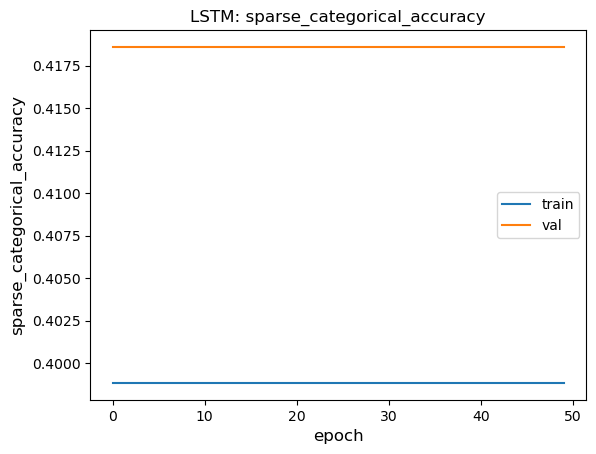

In [134]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("LSTM: " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

RNN

In [136]:
model_rnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model_rnn.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.6970 - sparse_categorical_accuracy: 0.5129 - val_loss: 0.6525 - val_sparse_categorical_accuracy: 0.5814 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.5719 - val_loss: 0.6249 - val_sparse_categorical_accuracy: 0.5814 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6163 - sparse_categorical_accuracy: 0.5822 - val_loss: 0.5715 - val_sparse_categorical_accuracy: 0.5814 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5474 - sparse_categorical_accuracy: 0.7345 - val_loss: 0.4856 - val_sparse_categorical_accuracy: 0.8953 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4606 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.3989 - val_sparse_categorical_accuracy: 0.8953 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - l

In [137]:
model_rnn = tf.keras.models.load_model("best_model.keras")

test_loss, test_acc = model_rnn.evaluate(test_x, test_y)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4106 - sparse_categorical_accuracy: 0.8407 
Test accuracy 0.8548387289047241
Test loss 0.3817227780818939


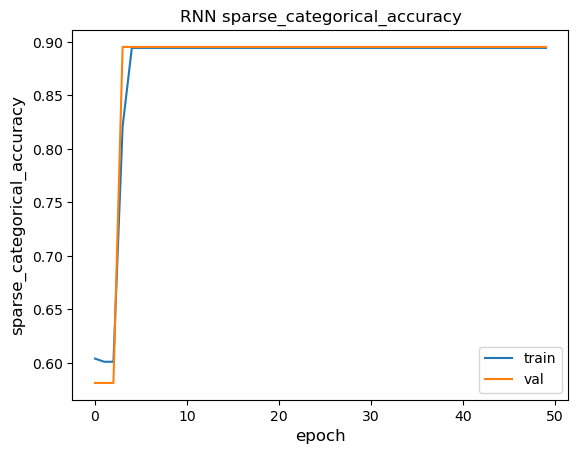

In [138]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("RNN " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

CNN

In [140]:
model_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model_cnn.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.7141 - sparse_categorical_accuracy: 0.5445 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.6163 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6085 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.4601 - val_sparse_categorical_accuracy: 0.8953 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3915 - sparse_categorical_accuracy: 0.9101 - val_loss: 0.3721 - val_sparse_categorical_accuracy: 0.8953 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3004 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.3369 - val_sparse_categorical_accuracy: 0.8953 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2594 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.3479 - val_sparse_categorical_accuracy: 0.8953 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

In [141]:
model_cnn = tf.keras.models.load_model("best_model.keras")

test_loss, test_acc = model_cnn.evaluate(test_x, test_y)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4106 - sparse_categorical_accuracy: 0.8407 
Test accuracy 0.8548387289047241
Test loss 0.3817227780818939


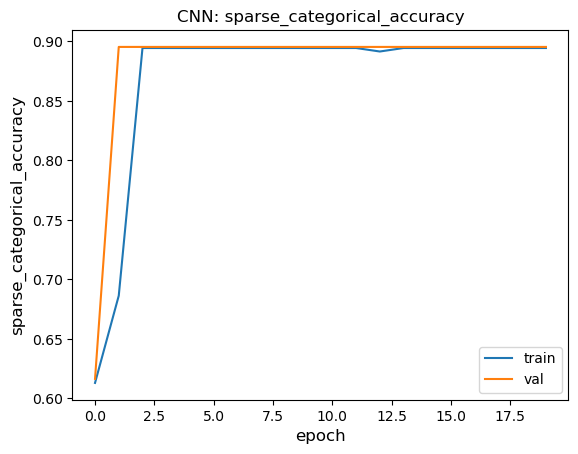

In [142]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("CNN: " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()